## Extracting expression matrix from ARCHS4 dataset

In [1]:
import pandas as pd
import numpy as np
import h5py
from pyensembl import EnsemblRelease
import squarify
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import seaborn as sns
from npy_append_array import NpyAppendArray

In [2]:
#load RNAse1 data (obtain the file from https://maayanlab.cloud/archs4/download.html and put it into the "inputs" folder)
f=h5py.File("../inputs/human_tpm_v11.h5","r")

In [3]:
list(f.keys())

['data', 'meta']

In [4]:
for key in f["meta/"]:
    print(key)

info
samples
transcripts


In [5]:
%%time
#Retrieving the full list of samples from the hdf5 file in order to get the index of the selected samples
geo_accession_array = list(f["meta/samples/geo_accession"].asstr())

CPU times: user 1min, sys: 55.2 ms, total: 1min
Wall time: 1min 1s


In [6]:
len(geo_accession_array)

441356

In [7]:
geo_accession_array[0:10]

['GSM741172',
 'GSM742939',
 'GSM742942',
 'GSM742946',
 'GSM741170',
 'GSM742947',
 'GSM742943',
 'GSM742944',
 'GSM742951',
 'GSM742940']

In [8]:
samples_types=pd.read_csv("../outputs/samples_types.csv",index_col=None)

In [9]:
samples_types.shape

(71961, 2)

In [10]:
samples_types.head()

,geo_id,type
0,GSM1240658,SKBR3
1,GSM1240657,SKBR3
2,GSM1240654,SKBR3
3,GSM1240655,SKBR3
4,GSM1240660,SKBR3


In [11]:
samples_types.set_index("geo_id",drop=False,inplace=True)

In [12]:
samples_types.head()

,geo_id,type
geo_id,,
GSM1240658,GSM1240658,SKBR3
GSM1240657,GSM1240657,SKBR3
GSM1240654,GSM1240654,SKBR3
GSM1240655,GSM1240655,SKBR3
GSM1240660,GSM1240660,SKBR3


In [13]:
#Getting the index of selected samples
geo_accession_array_as_dict = dict(zip(geo_accession_array,range(0,len(geo_accession_array))))
samples_index = samples_types.geo_id.map(geo_accession_array_as_dict.get).to_list()

In [14]:
samples_index[0:10]

[636, 1088, 2143, 2331, 2943, 3139, 3227, 3460, 25550, 25754]

In [15]:
len(samples_index)

71961

In [16]:
samples_types["index"]=samples_index

In [17]:
samples_types.head()

,geo_id,type,index
geo_id,,,
GSM1240658,GSM1240658,SKBR3,636
GSM1240657,GSM1240657,SKBR3,1088
GSM1240654,GSM1240654,SKBR3,2143
GSM1240655,GSM1240655,SKBR3,2331
GSM1240660,GSM1240660,SKBR3,2943


In [18]:
#checking constistency between ids of dataset and selected samples
geo_accession_array[78]

'GSM977029'

In [19]:
samples_types.to_csv("../outputs/samples_types_tpm.csv",index=None)

## Extracting gene expression matrix from h5

Retrieving expression data of selected samples.

In [20]:
expression_matrix=f["data/expression"][:,78:80]

In [21]:
expression_matrix.shape

(178136, 2)

In [22]:
#Retrieving expression data matrix of selected samples from archS4 dataset rows correspond to genes, columns to samples

# THE FOLLOWING 2 CELLS ARE 2 ALTERNATIVE WAYS OF ACHIEVING THE SAME.
# CELL 1 is probably fastest, but requires more (SO MUCH) memory

# THE 2 cells are commented out to prevent accidentally starting the very slow process

In [ ]:
%%time
# This will take a long time and require >50 gb (maybe 100gb) memory

#expression_matrix=f["data/expression"][:,sorted(samples_index)]
#np.save("/work1/laeb/selected_human_matrix_V11_tpm.npy",expression_matrix)

In [ ]:
# If the above fails due to memory limits you can try doing it with this instead
# It will due the read+write in chunks
# Its probably going to be quite slow (several hours slow)

""" commented out so you don't accidentally run this =)
%%time
#Retrieving expression data matrix of selected samples from archS4 dataset rows correspond to genes, columns to samples
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
ssi = sorted(samples_index)
# write bulk size is the number of rows written to the numpy file at a time
# larger bulk = faster write, but more memory
# if you run out of memory try a smaller bulk
bulk_size = 5000
fn = "..outputs/selected_human_matrix_V11_tpm.npy"
with NpyAppendArray(fn) as npaa:
    for chunk in chunker(ssi, bulk_size):
        npaa.append(f["data/expression"][:,chunk])
"""

In [25]:
expression_matrix=np.load("/work1/laeb/upload/selected_human_matrix_V11_tpm.npy", allow_pickle=True)

In [26]:
expression_matrix[0:10,0:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [27]:
expression_matrix.shape

(178136, 71961)

### Generating ID mapping

In [28]:
for key in f["meta/transcripts"]:
    print(key)

chromosome
ensembl_gene_id
ensembl_transcript_id
gene_biotype
gene_symbol
start_position
transcripts


In [29]:
ens_gids=list(f["meta/transcripts/ensembl_gene_id"].asstr())

In [30]:
ens_gids[0:10]

['ENSG00000228985',
 'ENSG00000282253',
 'ENSG00000282431',
 'ENSG00000237235',
 'ENSG00000223997',
 'ENSG00000282274',
 'ENSG00000282592',
 'ENSG00000270451',
 'ENSG00000225825',
 'ENSG00000282373']

In [31]:
len(ens_gids)

178136

In [32]:
gene_set=list(set(ens_gids))

In [33]:
len(gene_set)

38871

In [34]:
"missing" in gene_set

True

In [35]:
"nan" in gene_set

False

In [36]:
ens_tids=list(f["meta/transcripts/ensembl_transcript_id"].asstr())

In [37]:
len(ens_tids)

178136

In [38]:
"missing" in ens_tids

False

In [39]:
"nan" in ens_tids

False

In [40]:
gene_symbol=list(f["meta/transcripts/gene_symbol"].asstr())

In [41]:
len(gene_symbol)

178136

In [42]:
"missing" in gene_symbol

True

In [43]:
"nan" in gene_symbol

True

In [44]:
id_mapping=pd.DataFrame(ens_tids)

In [45]:
id_mapping["ens_gids"]=ens_gids
id_mapping["gene_symbol"]=gene_symbol
id_mapping.columns=["ens_tids","ens_gids","gene_symbol"]

In [46]:
id_mapping.head()

,ens_tids,ens_gids,gene_symbol
0,ENST00000448914,ENSG00000228985,TRDD3
1,ENST00000631435,ENSG00000282253,TRBD1
2,ENST00000632684,ENSG00000282431,TRBD1
3,ENST00000434970,ENSG00000237235,TRDD2
4,ENST00000415118,ENSG00000223997,TRDD1


Several ens_tids have no ens_gids or gene_symbol and are assigned as "missing" or "nan". Searching for missing genes...

In [47]:
len(id_mapping[id_mapping["gene_symbol"]=="missing"])

2615

In [48]:
len(id_mapping[id_mapping["ens_gids"]=="missing"])

2615

In [49]:
len(id_mapping[id_mapping["gene_symbol"]=="nan"])

7598

In [50]:
id_mapping.loc[(id_mapping["gene_symbol"]=="missing")|(id_mapping["gene_symbol"]=="nan")]

,ens_tids,ens_gids,gene_symbol
92,ENST00000631639,ENSG00000282054,nan
94,ENST00000621643,missing,missing
122,ENST00000631427,ENSG00000282543,nan
146,ENST00000632148,ENSG00000282353,nan
227,ENST00000634093,ENSG00000282610,nan
...,...,...,...
178121,ENST00000511202,ENSG00000198277,nan
178123,ENST00000595307,ENSG00000269651,nan
178124,ENST00000567652,ENSG00000227717,nan
178125,ENST00000452651,ENSG00000243831,nan


In [51]:
id_mapping.loc[(id_mapping["gene_symbol"]=="missing")|(id_mapping["gene_symbol"]=="nan")].to_csv("../outputs/missing_tids.csv")

In [52]:
id_mapping.shape

(178136, 3)

# Mapping missing transcripts to gene ids

In [53]:
#extracting gene ids from genome annotation

In [48]:
!pyensembl install --release 87 --species homo_sapiens

2022-02-23 12:25:54,696 - pyensembl.shell - INFO - Running 'install' for EnsemblRelease(release=87, species='homo_sapiens')
2022-02-23 12:25:54,697 - pyensembl.download_cache - INFO - Fetching /zhome/89/0/75762/.cache/pyensembl/GRCh38/ensembl87/Homo_sapiens.GRCh38.87.gtf.gz from URL ftp://ftp.ensembl.org/pub/release-87/gtf/homo_sapiens/Homo_sapiens.GRCh38.87.gtf.gz
2022-02-23 12:25:54,704 - datacache.download - INFO - Downloading ftp://ftp.ensembl.org/pub/release-87/gtf/homo_sapiens/Homo_sapiens.GRCh38.87.gtf.gz to /zhome/89/0/75762/.cache/pyensembl/GRCh38/ensembl87/Homo_sapiens.GRCh38.87.gtf.gz
2022-02-23 12:26:00,108 - pyensembl.download_cache - INFO - Fetching /zhome/89/0/75762/.cache/pyensembl/GRCh38/ensembl87/Homo_sapiens.GRCh38.cdna.all.fa.gz from URL ftp://ftp.ensembl.org/pub/release-87/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz
2022-02-23 12:26:00,109 - datacache.download - INFO - Downloading ftp://ftp.ensembl.org/pub/release-87/fasta/homo_sapiens/cdna/Homo_sapi

In [54]:
data = EnsemblRelease(87)
transcripts_87=data.transcript_ids()
len(transcripts_87)

198002

In [55]:
missing_tids=pd.read_csv("../outputs/missing_tids.csv",usecols=["ens_tids","ens_gids","gene_symbol"])

In [56]:
missing_tids.set_index("ens_tids",drop=False,inplace=True)

In [57]:
missing_tids.head()

,ens_tids,ens_gids,gene_symbol
ens_tids,,,
ENST00000631639,ENST00000631639,ENSG00000282054,NaN
ENST00000621643,ENST00000621643,missing,missing
ENST00000631427,ENST00000631427,ENSG00000282543,NaN
ENST00000632148,ENST00000632148,ENSG00000282353,NaN
ENST00000634093,ENST00000634093,ENSG00000282610,NaN


In [58]:
missing=[]
included=[]
for transcript in missing_tids.index.values:
    if transcript not in transcripts_87:
        missing.append(transcript)
    else:
        included.append(transcript)

In [59]:
len(missing)

1033

In [60]:
missing_genes={}
for transcript in included:
    gene_symbol=data.gene_name_of_transcript_id(transcript)
    gid=data.gene_ids_of_gene_name(gene_symbol)[0]
    missing_genes[transcript]=[gid,gene_symbol]

In [61]:
mapping_missing=pd.DataFrame.from_dict(missing_genes,orient="index")
mapping_missing.reset_index(inplace=True)
mapping_missing.columns=["ens_tids","ens_gids","gene_symbol"]
mapping_missing.set_index("ens_tids",drop=False,inplace=True)

In [62]:
mapping_missing.head()

,ens_tids,ens_gids,gene_symbol
ens_tids,,,
ENST00000621643,ENST00000621643,ENSG00000211804,TRDV1
ENST00000623845,ENST00000623845,ENSG00000280314,OR8K3
ENST00000624470,ENST00000624470,ENSG00000280204,OR1S1
ENST00000625105,ENST00000625105,ENSG00000279301,OR2T11
ENST00000380383,ENST00000380383,ENSG00000280021,OR51F1


In [63]:
len(mapping_missing.index.values)

9180

In [64]:
len(set(mapping_missing.index.values))

9180

In [65]:
id_mapping.set_index("ens_tids",drop='False',inplace=True)

In [66]:
id_mapping.head()

,ens_gids,gene_symbol
ens_tids,,
ENST00000448914,ENSG00000228985,TRDD3
ENST00000631435,ENSG00000282253,TRBD1
ENST00000632684,ENSG00000282431,TRBD1
ENST00000434970,ENSG00000237235,TRDD2
ENST00000415118,ENSG00000223997,TRDD1


In [67]:
id_mapping.loc[missing]

,ens_gids,gene_symbol
ens_tids,,
ENST00000631639,ENSG00000282054,nan
ENST00000631427,ENSG00000282543,nan
ENST00000632148,ENSG00000282353,nan
ENST00000634093,ENSG00000282610,nan
ENST00000632560,ENSG00000282040,nan
...,...,...
ENST00000627090,ENSG00000280794,nan
ENST00000628916,ENSG00000281510,nan
ENST00000420073,ENSG00000223798,nan


In [68]:
id_mapping[id_mapping["gene_symbol"]=="nan"]

,ens_gids,gene_symbol
ens_tids,,
ENST00000631639,ENSG00000282054,nan
ENST00000631427,ENSG00000282543,nan
ENST00000632148,ENSG00000282353,nan
ENST00000634093,ENSG00000282610,nan
ENST00000632560,ENSG00000282040,nan
...,...,...
ENST00000511202,ENSG00000198277,nan
ENST00000595307,ENSG00000269651,nan
ENST00000567652,ENSG00000227717,nan


In [69]:
id_mapping.loc[missing].to_csv("../outputs/missing_transcript_IDS_2.csv")

generate manually curated mapping of missing transcript ids

In [70]:
missing_curated=pd.read_csv("../inputs/curated/missing_ensembl_curated.csv",usecols=["TID","GID","gene_symbol"])
missing_curated.columns=["ens_tids","ens_gids","gene_symbol"]
missing_curated.set_index("ens_tids",drop=False,inplace=True)

In [71]:
missing_curated.head()

,ens_tids,ens_gids,gene_symbol
ens_tids,,,
ENST00000614992,ENST00000614992,ENSG00000276849,TRBC2
ENST00000620987,ENST00000620987,ENSG00000276849,TRBC2
ENST00000613720,ENST00000613720,ENSG00000276849,TRBC2
ENST00000622287,ENST00000622287,ENSG00000282657,IGHM
ENST00000622547,ENST00000622547,ENSG00000273539,IGHV3-73


In [72]:
missing_curated.shape

(351, 3)

In [73]:
len(set(missing_curated.index.values))

351

In [74]:
missing_total=[]
for transcript in missing:
    if transcript not in missing_curated.ens_tids.values:
        missing_total.append(transcript)

In [75]:
len(missing_total)

682

In [76]:
missing_total[0:10]

['ENST00000631639',
 'ENST00000631427',
 'ENST00000632148',
 'ENST00000634093',
 'ENST00000632560',
 'ENST00000633833',
 'ENST00000633570',
 'ENST00000626108',
 'ENST00000631869',
 'ENST00000633752']

In [77]:
id_mapping[id_mapping["gene_symbol"]=="missing"]

,ens_gids,gene_symbol
ens_tids,,
ENST00000621643,missing,missing
ENST00000623845,missing,missing
ENST00000624470,missing,missing
ENST00000625105,missing,missing
ENST00000380383,missing,missing
...,...,...
ENST00000622239,missing,missing
ENST00000619824,missing,missing
ENST00000619807,missing,missing


In [78]:
len(id_mapping[id_mapping["gene_symbol"]=="missing"])

2615

In [79]:
id_mapping[id_mapping["gene_symbol"]=="nan"]

,ens_gids,gene_symbol
ens_tids,,
ENST00000631639,ENSG00000282054,nan
ENST00000631427,ENSG00000282543,nan
ENST00000632148,ENSG00000282353,nan
ENST00000634093,ENSG00000282610,nan
ENST00000632560,ENSG00000282040,nan
...,...,...
ENST00000511202,ENSG00000198277,nan
ENST00000595307,ENSG00000269651,nan
ENST00000567652,ENSG00000227717,nan


In [80]:
len(id_mapping[id_mapping["gene_symbol"]=="nan"])

7598

In [81]:
not_found=[]
for transcript in missing_tids.index.values:
    if transcript in mapping_missing.index.values:
        id_mapping.loc[transcript]["ens_gids"]=mapping_missing.loc[transcript]["ens_gids"]
        id_mapping.loc[transcript]["gene_symbol"]=mapping_missing.loc[transcript]["gene_symbol"]
    elif transcript in missing_curated.index.values:
        id_mapping.loc[transcript]["ens_gids"]=missing_curated.loc[transcript]["ens_gids"]
        id_mapping.loc[transcript]["gene_symbol"]=missing_curated.loc[transcript]["gene_symbol"]
    else:
        not_found.append(transcript)

In [82]:
len(not_found)

682

In [83]:
id_mapping.loc["ENST00000621643"]

ens_gids       ENSG00000211804
gene_symbol              TRDV1
Name: ENST00000621643, dtype: object

In [84]:
id_mapping.loc["ENST00000631639"]

ens_gids       ENSG00000282054
gene_symbol                nan
Name: ENST00000631639, dtype: object

In [85]:
for transcript in id_mapping[id_mapping["gene_symbol"]=="nan"].index.values:
    id_mapping.loc[transcript]["gene_symbol"]=id_mapping.loc[transcript]["ens_gids"]

In [86]:
id_mapping.loc["ENST00000631639"]

ens_gids       ENSG00000282054
gene_symbol    ENSG00000282054
Name: ENST00000631639, dtype: object

In [87]:
id_mapping.shape

(178136, 2)

In [88]:
"missing" in id_mapping["gene_symbol"].values

False

In [89]:
"nan" in id_mapping["gene_symbol"].values

False

In [90]:
id_mapping.loc[id_mapping["gene_symbol"]=="nan"]

,ens_gids,gene_symbol
ens_tids,,


In [91]:
id_mapping.to_csv("../outputs/id_mapping_V11.csv")

In [92]:
id_mapping.head()

,ens_gids,gene_symbol
ens_tids,,
ENST00000448914,ENSG00000228985,TRDD3
ENST00000631435,ENSG00000282253,TRBD1
ENST00000632684,ENSG00000282431,TRBD1
ENST00000434970,ENSG00000237235,TRDD2
ENST00000415118,ENSG00000223997,TRDD1


## Discard transcripts will null expression in all samples

In [93]:
max_expression=np.amax(expression_matrix,axis=1)

In [94]:
len(max_expression)

178136

In [95]:
max_expression[0:10]

array([  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    , 519.9851], dtype=float32)

In [96]:
max_ind=np.argwhere(max_expression==0)

In [97]:
len(max_ind)

83

In [98]:
max_index=[int(index[0]) for index in max_ind]

In [99]:
len(max_index)

83

In [100]:
exp_mat=pd.DataFrame(expression_matrix)

In [101]:
exp_mat.head()

,0,1,2,3,4,5,6,7,8,9,...,71951,71952,71953,71954,71955,71956,71957,71958,71959,71960
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Retrieving geo_ids from the full list of geo_ids extracted from the hdf5 file

In [102]:
%%time
geo_ids=list(f["meta/samples/geo_accession"].asstr()[sorted(samples_index)])

CPU times: user 57 s, sys: 104 ms, total: 57.1 s
Wall time: 57 s


In [103]:
geo_ids[:10]

['GSM741172',
 'GSM741170',
 'GSM741171',
 'GSM907015',
 'GSM1193921',
 'GSM1098188',
 'GSM1193928',
 'GSM1048186',
 'GSM1216828',
 'GSM1241249']

In [104]:
exp_mat.columns=geo_ids

In [105]:
exp_mat.head()

,GSM741172,GSM741170,GSM741171,GSM907015,GSM1193921,GSM1098188,GSM1193928,GSM1048186,GSM1216828,GSM1241249,...,GSM5572862,GSM5577332,GSM5577333,GSM5577334,GSM5577335,GSM5577336,GSM5577337,GSM5580099,GSM5580100,GSM5580102
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
exp_mat.shape

(178136, 71961)

In [107]:
exp_mat.drop(index=max_index,inplace=True)

In [108]:
exp_mat.shape

(178053, 71961)

In [109]:
id_mapping.reset_index(inplace=True)

In [110]:
id_mapping.head()

,ens_tids,ens_gids,gene_symbol
0,ENST00000448914,ENSG00000228985,TRDD3
1,ENST00000631435,ENSG00000282253,TRBD1
2,ENST00000632684,ENSG00000282431,TRBD1
3,ENST00000434970,ENSG00000237235,TRDD2
4,ENST00000415118,ENSG00000223997,TRDD1


In [111]:
id_mapping.shape

(178136, 3)

In [112]:
id_mapping.iloc[max_index].to_csv("../outputs/null_genes.csv")

In [113]:
id_mapping.drop(index=max_index,inplace=True)

In [114]:
id_mapping.head()

,ens_tids,ens_gids,gene_symbol
9,ENST00000632609,ENSG00000282373,IGHD3-10
11,ENST00000632911,ENSG00000281939,IGHD3-9
12,ENST00000633504,ENSG00000282132,IGHD2-8
25,ENST00000390577,ENSG00000211917,IGHD3-16
28,ENST00000633353,ENSG00000282754,IGHD3-3


In [115]:
id_mapping.shape

(178053, 3)

In [116]:
id_mapping.to_csv("../outputs/id_mapping_V11_no_null.csv")

## Removing pseudogenes

In [117]:
biotype=list(f["meta/transcripts/gene_biotype"].asstr())

In [118]:
set(biotype)

{'IG_C_gene',
 'IG_C_pseudogene',
 'IG_D_gene',
 'IG_J_gene',
 'IG_J_pseudogene',
 'IG_V_gene',
 'IG_V_pseudogene',
 'IG_pseudogene',
 'TEC',
 'TR_C_gene',
 'TR_D_gene',
 'TR_J_gene',
 'TR_J_pseudogene',
 'TR_V_gene',
 'TR_V_pseudogene',
 'lncRNA',
 'miRNA',
 'missing',
 'polymorphic_pseudogene',
 'processed_pseudogene',
 'protein_coding',
 'pseudogene',
 'transcribed_processed_pseudogene',
 'transcribed_unitary_pseudogene',
 'transcribed_unprocessed_pseudogene',
 'translated_processed_pseudogene',
 'translated_unprocessed_pseudogene',
 'unitary_pseudogene',
 'unprocessed_pseudogene'}

In [119]:
len(biotype)

178136

In [120]:
for index in max_index: del biotype[index]

In [121]:
len(biotype)

178053

In [122]:
pseudogenes=["IG_C_pseudogene","IG_J_pseudogene","IG_V_pseudogene","IG_pseudogene","TR_J_pseudogene","TR_V_pseudogene","polymorphic_pseudogene","processed_pseudogene","pseudogene","transcribed_processed_pseudogene","transcribed_unitary_pseudogene","transcribed_unprocessed_pseudogene","translated_processed_pseudogene","translated_unprocessed_pseudogene","unitary_pseudogene","unprocessed_pseudogene"]

In [123]:
bool_array=[]
for x in biotype:
    bool_array.append(x not in pseudogenes)

In [124]:
sum(bool_array)# number of not pseudogene trancripts

159117

In [125]:
exp_mat.shape

(178053, 71961)

In [126]:
exp_mat.head()

,GSM741172,GSM741170,GSM741171,GSM907015,GSM1193921,GSM1098188,GSM1193928,GSM1048186,GSM1216828,GSM1241249,...,GSM5572862,GSM5577332,GSM5577333,GSM5577334,GSM5577335,GSM5577336,GSM5577337,GSM5580099,GSM5580100,GSM5580102
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.38166,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [127]:
exp_mat.shape

(178053, 71961)

In [128]:
id_mapping.shape

(178053, 3)

In [129]:
exp_mat.index=id_mapping["gene_symbol"]

In [130]:
exp_mat.head()

,GSM741172,GSM741170,GSM741171,GSM907015,GSM1193921,GSM1098188,GSM1193928,GSM1048186,GSM1216828,GSM1241249,...,GSM5572862,GSM5577332,GSM5577333,GSM5577334,GSM5577335,GSM5577336,GSM5577337,GSM5580099,GSM5580100,GSM5580102
gene_symbol,,,,,,,,,,,,,,,,,,,,,
IGHD3-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
IGHD3-9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
IGHD2-8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
IGHD3-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.38166,0.0,0.0
IGHD3-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [131]:
exp_mat.shape

(178053, 71961)

In [132]:
"missing" in exp_mat.index.values

False

In [133]:
"nan" in exp_mat.index.values

False

In [134]:
exp_mat=exp_mat[bool_array]

In [135]:
exp_mat.shape

(159117, 71961)

In [136]:
len(set(exp_mat.index.values))

20913

In [137]:
exp_mat.head()

,GSM741172,GSM741170,GSM741171,GSM907015,GSM1193921,GSM1098188,GSM1193928,GSM1048186,GSM1216828,GSM1241249,...,GSM5572862,GSM5577332,GSM5577333,GSM5577334,GSM5577335,GSM5577336,GSM5577337,GSM5580099,GSM5580100,GSM5580102
gene_symbol,,,,,,,,,,,,,,,,,,,,,
IGHD3-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
IGHD3-9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
IGHD2-8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
IGHD3-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.38166,0.0,0.0
IGHD3-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [138]:
"missing" in exp_mat.index.values

False

In [139]:
"nan" in exp_mat.index.values

False

In [140]:
id_mapping.head()


,ens_tids,ens_gids,gene_symbol
9,ENST00000632609,ENSG00000282373,IGHD3-10
11,ENST00000632911,ENSG00000281939,IGHD3-9
12,ENST00000633504,ENSG00000282132,IGHD2-8
25,ENST00000390577,ENSG00000211917,IGHD3-16
28,ENST00000633353,ENSG00000282754,IGHD3-3


In [141]:
id_mapping.shape

(178053, 3)

In [142]:
id_mapping_nop=id_mapping[bool_array]

In [143]:
id_mapping_nop.shape

(159117, 3)

In [144]:
"nan" in id_mapping_nop["gene_symbol"]

False

In [145]:
"missing" in id_mapping_nop["gene_symbol"]

False

In [146]:
id_mapping_nop.head()

,ens_tids,ens_gids,gene_symbol
9,ENST00000632609,ENSG00000282373,IGHD3-10
11,ENST00000632911,ENSG00000281939,IGHD3-9
12,ENST00000633504,ENSG00000282132,IGHD2-8
25,ENST00000390577,ENSG00000211917,IGHD3-16
28,ENST00000633353,ENSG00000282754,IGHD3-3


In [147]:
id_mapping_nop.to_csv("../outputs/id_mapping_V11_nop.csv")

In [163]:
np.save("/work1/laeb/genes_tpm_v11_tlevel.npy",exp_mat.index.values)
np.save("/work1/laeb/samples_tpm_v11_tlevel.npy",exp_mat.columns.values)
np.save("/work1/laeb/results_tpm_v11_tlevel.npy",exp_mat.values)

## Merging transcript level TPM to gene level TPM

#### merging synonym genes

In [149]:
id_mapping_nop=pd.read_csv("../outputs/id_mapping_V11_nop.csv",index_col=0)

In [150]:
id_mapping_nop.head()

,ens_tids,ens_gids,gene_symbol
9,ENST00000632609,ENSG00000282373,IGHD3-10
11,ENST00000632911,ENSG00000281939,IGHD3-9
12,ENST00000633504,ENSG00000282132,IGHD2-8
25,ENST00000390577,ENSG00000211917,IGHD3-16
28,ENST00000633353,ENSG00000282754,IGHD3-3


In [153]:
id_map2=id_mapping_nop.reset_index()
id_map2=id_map2.set_index("ens_gids")

In [154]:
id_map2

,index,ens_tids,gene_symbol
ens_gids,,,
ENSG00000282373,9,ENST00000632609,IGHD3-10
ENSG00000281939,11,ENST00000632911,IGHD3-9
ENSG00000282132,12,ENST00000633504,IGHD2-8
ENSG00000211917,25,ENST00000390577,IGHD3-16
ENSG00000282754,28,ENST00000633353,IGHD3-3
...,...,...,...
ENSG00000274457,177708,ENST00000619824,AC000041.10
ENSG00000277208,177718,ENST00000619807,RP11-12A20.11
ENSG00000279169,177731,ENST00000625019,PRAMEF13


In [155]:
id_map2.drop_duplicates("gene_symbol",inplace=True)

In [156]:
id_map2

,index,ens_tids,gene_symbol
ens_gids,,,
ENSG00000282373,9,ENST00000632609,IGHD3-10
ENSG00000281939,11,ENST00000632911,IGHD3-9
ENSG00000282132,12,ENST00000633504,IGHD2-8
ENSG00000211917,25,ENST00000390577,IGHD3-16
ENSG00000282754,28,ENST00000633353,IGHD3-3
...,...,...,...
ENSG00000275614,177694,ENST00000622239,RP11-12A20.12
ENSG00000274457,177708,ENST00000619824,AC000041.10
ENSG00000277208,177718,ENST00000619807,RP11-12A20.11


In [157]:
id_map2=id_map2.reset_index()
id_map2=id_map2.set_index("gene_symbol")

In [158]:
id_map2

,ens_gids,index,ens_tids
gene_symbol,,,
IGHD3-10,ENSG00000282373,9,ENST00000632609
IGHD3-9,ENSG00000281939,11,ENST00000632911
IGHD2-8,ENSG00000282132,12,ENST00000633504
IGHD3-16,ENSG00000211917,25,ENST00000390577
IGHD3-3,ENSG00000282754,28,ENST00000633353
...,...,...,...
RP11-12A20.12,ENSG00000275614,177694,ENST00000622239
AC000041.10,ENSG00000274457,177708,ENST00000619824
RP11-12A20.11,ENSG00000277208,177718,ENST00000619807


In [159]:
duplicated=id_map2[id_map2.duplicated("ens_gids")].ens_gids.values

In [160]:
id_map2=id_map2.reset_index()
id_map2=id_map2.set_index("ens_gids")

In [161]:
id_map2.loc[duplicated].to_csv("../outputs/duplicated_genes.csv")

In [162]:
# Manuel curation of the duplicated genes

In [164]:
id_map2=pd.read_csv("../inputs/curated/duplicated_genes_curated.csv")

In [165]:
id_map2[id_map2["type"]!="protein_coding"]

,ens_gids,gene_symbol,new_symbol,type
26,ENSG00000204677,FAM153C,FAM153CP,pseudogene
27,ENSG00000204677,FAM153CP,FAM153CP,pseudogene
60,ENSG00000212719,C17orf51,LINC02693,RNA
61,ENSG00000212719,LINC02693,LINC02693,RNA
62,ENSG00000277288,C10orf142,LINC02881,RNA
63,ENSG00000277288,LINC02881,LINC02881,RNA
66,ENSG00000125462,C1orf61,MIR9-1HG,RNA
67,ENSG00000125462,MIR9-1HG,MIR9-1HG,RNA
80,ENSG00000188086,PRSS45,PRSS45P,pseudogene
81,ENSG00000188086,PRSS45P,PRSS45P,pseudogene


In [166]:
id_mapping_nop.set_index("gene_symbol",drop=False,inplace=True)

In [167]:
id_mapping_nop.head()

,ens_tids,ens_gids,gene_symbol
gene_symbol,,,
IGHD3-10,ENST00000632609,ENSG00000282373,IGHD3-10
IGHD3-9,ENST00000632911,ENSG00000281939,IGHD3-9
IGHD2-8,ENST00000633504,ENSG00000282132,IGHD2-8
IGHD3-16,ENST00000390577,ENSG00000211917,IGHD3-16
IGHD3-3,ENST00000633353,ENSG00000282754,IGHD3-3


In [168]:
id_mapping_nop.shape

(159117, 3)

In [169]:
id_mapping_nop.drop(id_map2[id_map2["type"]!="protein_coding"].gene_symbol.values,inplace=True)

In [170]:
id_mapping_nop.shape

(159052, 3)

In [171]:
id_mapping_nop.to_csv("../outputs/id_mapping_V11_clean.csv")

In [172]:
genes=np.load("/work1/laeb/genes_tpm_v11_tlevel.npy",allow_pickle=True)
samples=np.load("/work1/laeb/samples_tpm_v11_tlevel.npy",allow_pickle=True)
X=np.load("/work1/laeb/results_tpm_v11_tlevel.npy",allow_pickle=True)
results=pd.DataFrame(X,index=genes,columns=samples)

In [173]:
results.head()

,GSM741172,GSM741170,GSM741171,GSM907015,GSM1193921,GSM1098188,GSM1193928,GSM1048186,GSM1216828,GSM1241249,...,GSM5572862,GSM5577332,GSM5577333,GSM5577334,GSM5577335,GSM5577336,GSM5577337,GSM5580099,GSM5580100,GSM5580102
IGHD3-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
IGHD3-9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
IGHD2-8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
IGHD3-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.38166,0.0,0.0
IGHD3-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [174]:
results.shape

(159117, 71961)

In [175]:
results.drop(id_map2[id_map2["type"]!="protein_coding"].gene_symbol.values,inplace=True)

In [176]:
results.shape

(159052, 71961)

In [177]:
id_map2[id_map2["type"]=="protein_coding"]

,ens_gids,gene_symbol,new_symbol,type
0,ENSG00000157399,ARSE,ARSL,protein_coding
1,ENSG00000157399,ARSL,ARSL,protein_coding
2,ENSG00000135390,ATP5G2,ATP5MC2,protein_coding
3,ENSG00000135390,ATP5MC2,ATP5MC2,protein_coding
4,ENSG00000148120,AOPEP,AOPEP,protein_coding
...,...,...,...,...
113,ENSG00000109685,WHSC1,NSD2,protein_coding
114,ENSG00000112761,CCN6,CCN6,protein_coding
115,ENSG00000112761,WISP3,CCN6,protein_coding
116,ENSG00000182093,GET1,GET1,protein_coding


In [178]:
change=id_map2[id_map2["type"]=="protein_coding"]

In [179]:
change.set_index("gene_symbol",inplace=True)

In [180]:
change

,ens_gids,new_symbol,type
gene_symbol,,,
ARSE,ENSG00000157399,ARSL,protein_coding
ARSL,ENSG00000157399,ARSL,protein_coding
ATP5G2,ENSG00000135390,ATP5MC2,protein_coding
ATP5MC2,ENSG00000135390,ATP5MC2,protein_coding
AOPEP,ENSG00000148120,AOPEP,protein_coding
...,...,...,...
WHSC1,ENSG00000109685,NSD2,protein_coding
CCN6,ENSG00000112761,CCN6,protein_coding
WISP3,ENSG00000112761,CCN6,protein_coding


In [181]:
results.head()

,GSM741172,GSM741170,GSM741171,GSM907015,GSM1193921,GSM1098188,GSM1193928,GSM1048186,GSM1216828,GSM1241249,...,GSM5572862,GSM5577332,GSM5577333,GSM5577334,GSM5577335,GSM5577336,GSM5577337,GSM5580099,GSM5580100,GSM5580102
IGHD3-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
IGHD3-9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
IGHD2-8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
IGHD3-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.38166,0.0,0.0
IGHD3-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [182]:
for gene in change.index.values:
    results.rename(index={gene:change.loc[gene].new_symbol},inplace=True)

In [183]:
gene_level_tpm=results.groupby(results.index).sum()

In [184]:
gene_level_tpm.shape

(20846, 71961)

In [185]:
gene_level_tpm.head()

,GSM741172,GSM741170,GSM741171,GSM907015,GSM1193921,GSM1098188,GSM1193928,GSM1048186,GSM1216828,GSM1241249,...,GSM5572862,GSM5577332,GSM5577333,GSM5577334,GSM5577335,GSM5577336,GSM5577337,GSM5580099,GSM5580100,GSM5580102
A1BG,1.514984,1.316501,0.945544,12.863701,71.141045,0.738105,134.292114,10.272301,2.855723,0.000000,...,0.778685,6.074946,6.227352,5.103860,8.809099,7.493229,7.746690,42.761230,35.295048,35.235378
A1CF,0.208822,0.199274,0.138544,0.058604,0.301775,0.034464,1.374310,0.267306,13.903001,0.000000,...,0.163493,0.129097,0.266828,0.162259,0.165147,0.261044,0.246418,0.013703,0.031029,0.020903
A2M,61.154045,141.594360,62.881958,109.156868,0.000000,313.137146,0.000000,216.393066,22.510412,0.000000,...,0.000000,0.130720,0.426572,0.000000,0.507422,0.200596,0.000000,314.406342,426.812805,311.372803
A2ML1,0.373835,0.262869,0.266668,0.799892,0.655797,0.109945,0.366945,4.065595,0.190527,1.748747,...,0.112173,1.403640,2.326312,2.850472,3.334096,3.415315,2.629406,0.064991,0.255675,0.041696
A3GALT2,0.722773,1.094620,0.645631,0.000000,0.000000,0.458957,0.000000,4.969500,0.000000,0.000000,...,0.000000,0.457722,0.104935,0.179656,0.000000,0.313955,0.304647,0.000000,0.000000,0.151392


In [186]:
np.save("/work1/laeb/genes_tpm_v11",gene_level_tpm.index.values)
np.save("/work1/laeb/samples_tpm_v11",gene_level_tpm.columns.values)
np.save("/work1/laeb/results_tpm_v11",gene_level_tpm.values)

In [187]:
for gene in change.index.values:
    id_mapping_nop.rename(index={gene:change.loc[gene].new_symbol},inplace=True)

In [189]:
id_mapping_nop.to_csv("../outputs/id_mapping_V11_clean.csv")

### Plot

In [190]:
samples_types=pd.read_csv("../outputs/samples_types_tpm.csv",index_col=0)

In [191]:
samples_types

,type,index
geo_id,,
GSM1240658,SKBR3,636
GSM1240657,SKBR3,1088
GSM1240654,SKBR3,2143
GSM1240655,SKBR3,2331
GSM1240660,SKBR3,2943
...,...,...
GSM4213269,Tlymphocyte,371557
GSM1536833,Gastric Epithelial Cell,25686
GSM1536834,Gastric Epithelial Cell,32163


In [192]:
n_samples=pd.DataFrame(samples_types["type"].value_counts(ascending=False))
n_samples.columns=["counts"]

In [193]:
n_samples.head()

,counts
Pancreatic Islet,11296
Fibroblast,9740
Neuron,4789
HEK293,4001
MCF7,3984


In [194]:
n_samples.tail()

,counts
Thymocyte,11
MT4,10
Kupffe,8
Gastric Epithelial Cell,4
Primary Liver Cell,2


### Dropping out cell types with less than 10 samples

In [195]:
low_samps=[]
drop_cell=[]
for cell_type in n_samples[n_samples["counts"]<10].index.values:
    low_samps.extend(list(samples_types[samples_types["type"]==cell_type].index.values))
    drop_cell.append(cell_type)
    

In [196]:
len(low_samps)

14

In [197]:
low_samps

['GSM1686453',
 'GSM1686448',
 'GSM1686446',
 'GSM1686450',
 'GSM1686451',
 'GSM1686447',
 'GSM1686452',
 'GSM1686449',
 'GSM1536833',
 'GSM1536834',
 'GSM1536835',
 'GSM1536836',
 'GSM2326089',
 'GSM2326088']

In [198]:
drop_cell

['Kupffe', 'Gastric Epithelial Cell', 'Primary Liver Cell']

In [199]:
gene_level_tpm.shape

(20846, 71961)

In [200]:
gene_level_tpm.drop(columns=low_samps,inplace=True)

In [201]:
gene_level_tpm.shape

(20846, 71947)

In [202]:
samples_types.head()

,type,index
geo_id,,
GSM1240658,SKBR3,636
GSM1240657,SKBR3,1088
GSM1240654,SKBR3,2143
GSM1240655,SKBR3,2331
GSM1240660,SKBR3,2943


In [203]:
samples_types.drop(index=low_samps,inplace=True)

In [204]:
n_samples=pd.DataFrame(samples_types["type"].value_counts(ascending=False))
n_samples.columns=["counts"]

In [205]:
n_samples.tail()

,counts
JEG3,22
MG63,22
NCIH460,14
Thymocyte,11
MT4,10


In [206]:
n_samples.to_csv("../outputs/n_samples.csv")

In [207]:
np.save("/work1/laeb/genes_tpm_v11_clean.npy",gene_level_tpm.index.values)
np.save("/work1/laeb/samples_tpm_v11_clean.npy",gene_level_tpm.columns.values)
np.save("/work1/laeb/results_tpm_v11_clean.npy",gene_level_tpm.values)

In [208]:
genes=np.load("/work1/laeb/genes_tpm_v11_clean.npy",allow_pickle=True)
samples=np.load("/work1/laeb/samples_tpm_v11_clean.npy",allow_pickle=True)
X=np.load("/work1/laeb/results_tpm_v11_clean.npy",allow_pickle=True)
results=pd.DataFrame(X,index=genes,columns=samples)

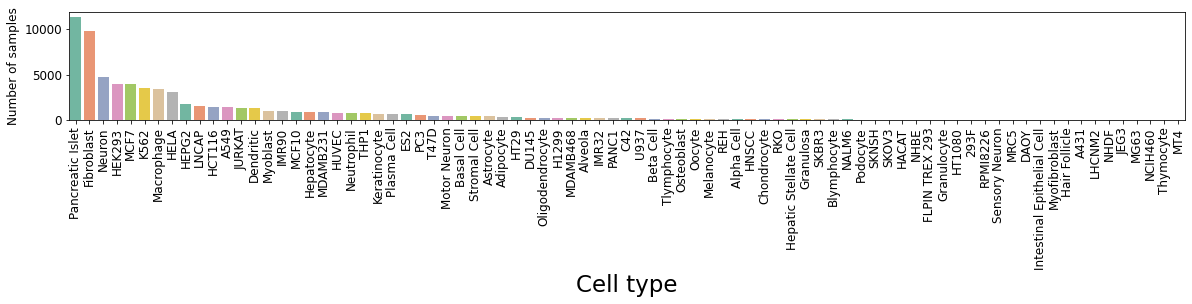

In [210]:
plt.figure(figsize=(20, 2))
ax=sns.barplot(data=n_samples,x=n_samples.index.values,y=n_samples["counts"].values, linewidth=0.6,palette="Set2",order=n_samples.index.values)
ax.set_xlabel("Cell type",fontsize=23)
ax.set_ylabel("Number of samples",fontsize=12)
ax.tick_params(labelsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.figure.savefig("../outputs/tpm_nsamps.svg",bbox_inches="tight",facecolor="w")

In [211]:
percentage=pd.DataFrame((n_samples["counts"]/n_samples["counts"].sum())*100)

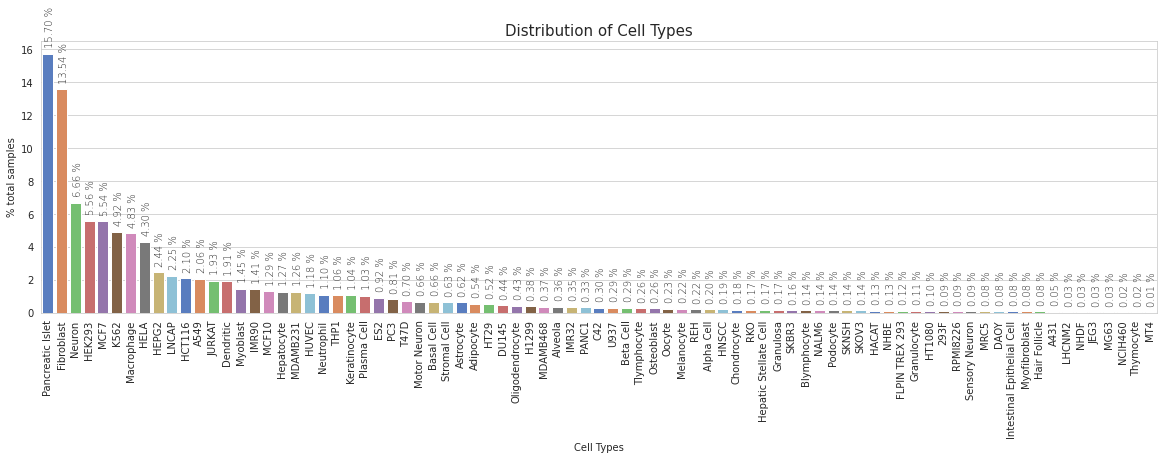

In [212]:
#Seaborn Horizontal barplot
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(20,5))
ax = sns.barplot(x=percentage.index, y="counts", data=percentage, ci=None, palette="muted",orient='v' )
ax.set_title("Distribution of Cell Types", fontsize=15)
ax.set_xlabel ("Cell Types")
ax.set_ylabel ("% total samples")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for rect in ax.patches:
    ax.text (rect.get_x() + (rect.get_width()/2) / 2,rect.get_height()+0.5,"%.2f %%"% rect.get_height(), weight='light',rotation=90 )
bar.savefig("../outputs/cell_types_percentage.svg",bbox_inches="tight")

In [213]:
n_samples.index.values

array(['Pancreatic Islet', 'Fibroblast', 'Neuron', 'HEK293', 'MCF7',
       'K562', 'Macrophage', 'HELA', 'HEPG2', 'LNCAP', 'HCT116', 'A549',
       'JURKAT', 'Dendritic', 'Myoblast', 'IMR90', 'MCF10', 'Hepatocyte',
       'MDAMB231', 'HUVEC', 'Neutrophil', 'THP1', 'Keratinocyte',
       'Plasma Cell', 'ES2', 'PC3', 'T47D', 'Motor Neuron', 'Basal Cell',
       'Stromal Cell', 'Astrocyte', 'Adipocyte', 'HT29', 'DU145',
       'Oligodendrocyte', 'H1299', 'MDAMB468', 'Alveola', 'IMR32',
       'PANC1', 'C42', 'U937', 'Beta Cell', 'Tlymphocyte', 'Osteoblast',
       'Oocyte', 'Melanocyte', 'REH', 'Alpha Cell', 'HNSCC',
       'Chondrocyte', 'RKO', 'Hepatic Stellate Cell', 'Granulosa',
       'SKBR3', 'Blymphocyte', 'NALM6', 'Podocyte', 'SKNSH', 'SKOV3',
       'HACAT', 'NHBE', 'FLPIN TREX 293', 'Granulocyte', 'HT1080', '293F',
       'RPMI8226', 'Sensory Neuron', 'MRC5', 'DAOY',
       'Intestinal Epithelial Cell', 'Myofibroblast', 'Hair Follicle',
       'A431', 'LHCNM2', 'NHDF', 'JEG3', 

In [220]:
def cell_type_dist(n_samples):
    sizes=list(n_samples["counts"].values)
    label=list(n_samples.index.values)
    norm = colors.Normalize(vmin=min(n_samples.counts), vmax=max(n_samples.counts))
    my_colors = [cm.coolwarm(norm(value)) for value in n_samples.counts]
    #color=['red','blue','green','pink','orange','grey']
    squarify.plot(sizes=sizes, label=label, alpha=0.6, pad=True,color=my_colors)
    plt.axis('off')
    name="../outputs/n_samples.svg"
    plt.savefig(name)
    plt.show()

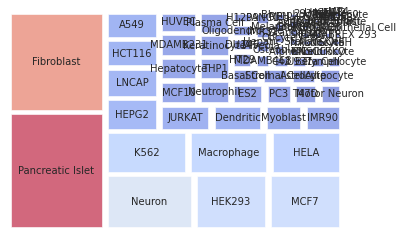

In [221]:
cell_type_dist(n_samples)